In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


# 数据预处理

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data preprocessing transforms for train and test sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



# 导入数据

In [ ]:
# Load train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)



In [48]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# 网络结构

In [ ]:
# 定义网络结构
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False,dropout=0.5):   
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(  
            nn.Conv2d(in_channels= 3, out_channels= 64, kernel_size=11, stride=4, padding=2), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2),                 
            nn.Conv2d(in_channels= 64, out_channels= 192, kernel_size=5, padding=2),          
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  
            nn.Conv2d(in_channels=192, out_channels= 384, kernel_size=3, padding=1),         
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),          
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),          
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # 自适应平均池化层

        self.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features= 256 * 6 * 6, out_features= 4096),  # 6*6是经过5次池化后的结果
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features= 4096, out_features= 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x) #自适应池化
        x = torch.flatten(x, start_dim=1) #展平   
        x = self.fc(x)
        return x

In [49]:
net = AlexNet().to(device)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): 

# 损失函数和优化器

In [ ]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 训练网络

In [ ]:
from tqdm import tqdm

# 训练网络
save_path = './AlexNet.pth'
train_steps = len(trainloader)



def train(net,train_data,valid_data,epochs,optimizer,criterion):
    train_loss_history = []
    valid_loss_history = []

    train_acc_history = []
    valid_acc_history = []

    best_acc = 0.0

    # 训练

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

        net.train()
        for i, data in tqdm(enumerate(train_data),total=len(train_data)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() # 累加loss

            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)


        train_loss = train_loss / len(train_data)
        train_acc = train_acc.double() / len(train_data)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        print('Epoch: [{}/{}], train_loss: {:.4f}, train_acc: {:.4f}'.format(epoch + 1, epochs, train_loss, train_acc))
        
        # 验证

        net.eval()
        with torch.no_grad():
            for i, data in enumerate(testloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                valid_acc += torch.sum(preds == labels.data).detach().cpu().numpy()

            valid_loss = valid_loss / len(valid_data)
            valid_acc = valid_acc.double() / len(valid_data)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            print('Epoch: [{}/{}], valid_loss: {:.4f}, valid_acc: {:.4f}'.format(epoch + 1, epochs, valid_loss, valid_acc))
            
        if valid_acc > best_acc:
            best_acc = valid_acc
            print('Best epoch: {}, best acc: {:.4f}'.format(epoch + 1, best_acc))
            torch.save(net.state_dict(), save_path)

    # 可视化
    plt.figure()
    plt.plot(train_loss_history, label='train loss')
    plt.plot(valid_loss_history, label='valid loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc_history, label='train acc')
    plt.plot(valid_acc_history, label='valid acc')
    plt.legend()
    plt.show()

    print('Finished Training')
    


In [ ]:
train(net,trainloader,testloader,10,optimizer,criterion)

# 预测

In [ ]:
# 预测
net.load_state_dict(torch.load(save_path))
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy on test set: %d %% ' % (100 * correct / total))

# 保存模型
torch.save(net.state_dict(), './AlexNet.pth')



In [43]:
# 加载模型
net.load_state_dict(torch.load('./AlexNet.pth'), strict=False)
net.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): 

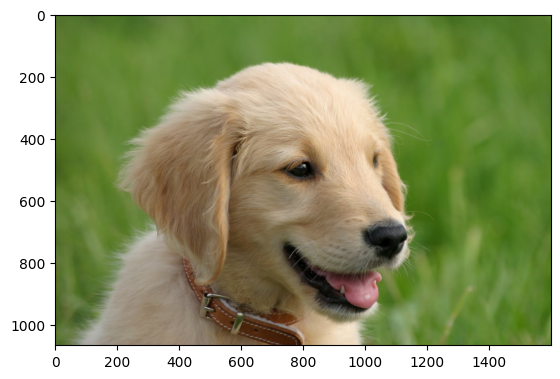

In [46]:
from torchvision import transforms
from PIL import Image

# Load and preprocess the input image
input_image = Image.open('dog_test.jpg')
input_tensor = transform_test(input_image).unsqueeze(0)

# 显示图片
plt.imshow(input_image)


In [47]:
# Set the model to evaluation mode
net.eval()

# Forward pass through the network
with torch.no_grad():
    outputs = net(input_tensor)

# Get the predicted class labels
_, predicted = torch.max(outputs.data, 1)

# 输出预测结果
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(1)))


Predicted:  truck


In [54]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([51.5693]),
indices=tensor([9]))

# 加载预训练模型并训练自己的数据集

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# 加载数据集
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


In [50]:
# 加载预训练模型
model = torchvision.models.alexnet(pretrained=True)

# 将模型最后一层替换为新的全连接层（10分类）
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

print(model)

C:\Users\ZeroLoveSeA\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ZeroLoveSeA\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ZeroLoveSeA/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:23<00:00, 10.4MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [52]:
model.classifier[6]

Linear(in_features=4096, out_features=10, bias=True)

In [ ]:


# 将模型转换为训练模式
model.train()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
for epoch in range(10):  # 迭代 10 次

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入和标签
        inputs, labels = data

        # 梯度清零
        optimizer.zero_grad()

        # 正向传播、反向传播和优化
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 100 == 99:    # 每 100 批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


In [ ]:
# 将模型转换为评估模式
model.eval()

# 在测试集上进行评估
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# 加载预训练模型
alexnet = models.alexnet(pretrained=True)

# 加载预训练模型的权重
state_dict = alexnet.state_dict()

# 创建自己的网络结构
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # 定义自己的网络结构

    def forward(self, x):
        # 定义网络的前向传播过程
        return x

# 将预训练模型的权重应用于自己的网络结构
mynet = MyNet()
mynet_dict = mynet.state_dict()

# 删除不匹配的键
state_dict = {k: v for k, v in state_dict.items() if k in mynet_dict}

# 更新自己的网络结构的权重
mynet_dict.update(state_dict)
mynet.load_state_dict(mynet_dict)
